<a href="https://colab.research.google.com/github/bathanh0309/dl_crack_segmentation/blob/main/Cau1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Câu 1. Thư mục data_01 gồm các thư mục "rgb", "BW", "rgb_test", "BW_test” chứa hình ảnh vết nứt
và mặt nạ vết nứt (mask) (với các điểm ảnh trắng biểu diễn cho vết nứt). Sinh viên thực hiện và báo cáo
các nội dung sau:

a. Xây dựng một mô hình học sâu (không dùng mô hình YOLO) để phân vùng vết nứt. Sử dụng
một bảng để liệt kê và mô tả thông tin của tất cả các lớp trong mô hình, đồng thời giải thích lý
do chọn kiến trúc mô hình đó.

b. Chọn và mô tả hàm mất mát (loss function) và phương pháp tối ưu hóa sinh viên sử dụng. Giải
thích lý do lựa chọn.

c. Huấn luyện mô hình sử dụng hai thư mục “rgb”, “BW” là dữ liệu huấn luyện; 2 thư mục
"rgb_test" và “BW_test” là thư mục kiểm tra. Báo cáo độ chính xác phân vùng và giá trị hàm
mất mát (loss) của mô hình trên tập huấn luyện và kiểm tra trong ít nhất 20 epochs.

d. Kiểm tra mô hình với 20 ảnh trong thư mục kiểm tra “rgb_test", hiển thị kết quả phân vùng vết
nứt của mô hình, hiển thị mặt nạ vết nứt tương ứng. So sánh kết quả dự đoán và mặt nạ vết nứt,
và phân tích kết quả trong báo cáo.

e. Nêu giải pháp cải thiện kết quả

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Cell 1: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms as T

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from tqdm import tqdm
import random

from PIL import Image, ImageOps
import torchvision.transforms.functional as TF

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [6]:
# Cell 2: Define U-Net Model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        enc3 = self.encoder3(x)
        x = self.pool3(enc3)

        enc4 = self.encoder4(x)
        x = self.pool4(enc4)

        x = self.bottleneck(x)

        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)

        logits = self.out_conv(x)
        return logits


model = UNet(in_channels=3, out_channels=1).to(device)
print(f'Model created with {sum(p.numel() for p in model.parameters()):,} parameters')

Model created with 31,043,521 parameters


In [7]:
# Cell 3: Define Loss Functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (probs_flat * targets_flat).sum()
        dice = (2. * intersection + self.smooth) / (probs_flat.sum() + targets_flat.sum() + self.smooth)
        return 1 - dice

pos_weight = torch.tensor([5.0], device=device)

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.3, dice_weight=0.7, pos_weight=None):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        if pos_weight is None:
            self.bce_loss = nn.BCEWithLogitsLoss()
        else:
            self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice_loss = DiceLoss()

    def forward(self, logits, targets):
        bce = self.bce_loss(logits, targets)
        dice = self.dice_loss(logits, targets)
        return self.bce_weight * bce + self.dice_weight * dice


criterion = CombinedLoss(bce_weight=0.3, dice_weight=0.7, pos_weight=pos_weight).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print('Loss function: Combined BCE + Dice Loss')
print('Optimizer: Adam with learning rate = 1e-4')

Loss function: Combined BCE + Dice Loss
Optimizer: Adam with learning rate = 1e-4


In [8]:
# Cell 4: Define Dataset
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(512, 512), augment=False, normalize=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.augment = augment
        self.normalize = normalize

        self.images = sorted(
          glob.glob(os.path.join(image_dir, '*.jpg')) +
          glob.glob(os.path.join(image_dir, '*.JPG'))
        )

        self.masks = []
        for img_path in self.images:
            img_name = os.path.basename(img_path)
            img_stem = os.path.splitext(img_name)[0]

            possible_exts = ['.jpg', '.JPG', '.png', '.jpeg', '.JPEG', '.PNG']
            mask_path = None
            for ext in possible_exts:
              candidate = os.path.join(mask_dir, img_stem + ext)
              if os.path.exists(candidate):
                mask_path = candidate
                break

            if mask_path is not None:
              self.masks.append(mask_path)
            else:
              print(f'Warning: Mask not found for {img_name}')

        assert len(self.images) == len(self.masks), "Number of images and masks must match"
        print(f'Found {len(self.images)} image-mask pairs in {image_dir}')

        self.image_resize = T.Resize(img_size, interpolation=T.InterpolationMode.BILINEAR)
        self.mask_resize = T.Resize(img_size, interpolation=T.InterpolationMode.NEAREST)

        if self.normalize:
            self.image_normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            self.image_normalize = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(img_path).convert('RGB')
        image = ImageOps.exif_transpose(image)
        mask = Image.open(mask_path).convert('L')

        image = self.image_resize(image)
        mask = self.mask_resize(mask)

        if self.augment:
            if random.random() > 0.5:
                image = T.functional.hflip(image)
                mask = T.functional.hflip(mask)
            if random.random() > 0.5:
                image = T.functional.vflip(image)
                mask = T.functional.vflip(mask)

        image = T.functional.to_tensor(image)
        mask = T.functional.to_tensor(mask)

        if self.image_normalize is not None:
            image = self.image_normalize(image)

        mask = (mask > 0.5).float()

        return image, mask

In [9]:
# Cell 5: Create DataLoaders
train_img_dir = "/content/drive/MyDrive/deeplearning_final/data_cau1/rgb"
train_mask_dir = "/content/drive/MyDrive/deeplearning_final/data_cau1/BW"
test_img_dir = "/content/drive/MyDrive/deeplearning_final/data_cau1/rgb_test"
test_mask_dir = "/content/drive/MyDrive/deeplearning_final/data_cau1/BW_test"

img_size = (512, 512)
batch_size = 4

train_dataset = CrackDataset(train_img_dir, train_mask_dir, img_size=img_size, augment=True, normalize=True)
test_dataset = CrackDataset(test_img_dir, test_mask_dir, img_size=img_size, augment=False, normalize=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)  # num_workers=2 cho Colab
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f'\nTraining samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Batch size: {batch_size}')

Found 416 image-mask pairs in /content/drive/MyDrive/deeplearning_final/data_cau1/rgb
Found 29 image-mask pairs in /content/drive/MyDrive/deeplearning_final/data_cau1/rgb_test

Training samples: 416
Test samples: 29
Batch size: 4


In [10]:
# Cell 6: Define Metrics Functions
def calculate_pixel_accuracy(preds, targets):
    preds_binary = (preds > 0.5).float()
    correct = (preds_binary == targets).float().sum()
    total = targets.numel()
    return (correct / total).item()


def calculate_dice_coefficient(preds, targets, smooth=1.0):
    preds_binary = (preds > 0.5).float()
    preds_flat = preds_binary.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    dice = (2. * intersection + smooth) / (preds_flat.sum() + targets_flat.sum() + smooth)
    return dice.item()


def calculate_iou(preds, targets, smooth=1.0):
    preds_binary = (preds > 0.5).float()
    preds_flat = preds_binary.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    union = preds_flat.sum() + targets_flat.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

In [11]:
# Cell 7: Define Training and Validation Functions
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_dice = 0.0
    running_iou = 0.0

    progress_bar = tqdm(dataloader, desc='Training')
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = torch.sigmoid(logits)
            acc = calculate_pixel_accuracy(preds, masks)
            dice = calculate_dice_coefficient(preds, masks)
            iou = calculate_iou(preds, masks)

        running_loss += loss.item()
        running_accuracy += acc
        running_dice += dice
        running_iou += iou

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{dice:.4f}'})

    num_batches = len(dataloader)
    return {
        'loss': running_loss / num_batches,
        'accuracy': running_accuracy / num_batches,
        'dice': running_dice / num_batches,
        'iou': running_iou / num_batches
    }


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_dice = 0.0
    running_iou = 0.0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = criterion(logits, masks)

            preds = torch.sigmoid(logits)
            acc = calculate_pixel_accuracy(preds, masks)
            dice = calculate_dice_coefficient(preds, masks)
            iou = calculate_iou(preds, masks)

            running_loss += loss.item()
            running_accuracy += acc
            running_dice += dice
            running_iou += iou

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'dice': f'{dice:.4f}'})

    num_batches = len(dataloader)
    if num_batches == 0:
      return{
          'loss': 0.0,
          'accuracy': 0.0,
          'dice': 0.0
      }
    return {
        'loss': running_loss / num_batches,
        'accuracy': running_accuracy / num_batches,
        'dice': running_dice / num_batches,
        'iou': running_iou / num_batches
    }

In [12]:
# Cell 8: Training Loop + Resume từ checkpoint
import os

checkpoint_path = '/content/drive/MyDrive/deeplearning_final/checkpoint_unet.pth'
num_epochs = 20  # tổng số epoch bạn muốn train

# Khởi tạo mặc định (nếu không có checkpoint)
history = {
    'train_loss': [], 'train_acc': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_acc': [], 'val_dice': [], 'val_iou': []
}
best_dice = 0.0
start_epoch = 0

print('\n' + '='*70)
print('STARTING TRAINING')
print('='*70)

# 1) Nếu có checkpoint thì load để train tiếp
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    history = checkpoint['history']
    best_dice = checkpoint['best_dice']
    start_epoch = checkpoint['epoch'] + 1  # tiếp tục từ epoch kế tiếp

    print(f'>> Found checkpoint, resume from epoch {start_epoch}/{num_epochs}')
    print(f'>> Best val Dice before: {best_dice:.4f}')
else:
    print('>> No checkpoint found, start training from scratch.')

# 2) Vòng lặp train từ start_epoch tới num_epochs
for epoch in range(start_epoch, num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 70)

    train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_metrics = validate(model, test_loader, criterion, device)

    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])

    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])

    print(f'\nEpoch {epoch+1} Summary:')
    print(f'  Train - Loss: {train_metrics["loss"]:.4f}, Acc: {train_metrics["accuracy"]:.4f}, '
          f'Dice: {train_metrics["dice"]:.4f}, IoU: {train_metrics["iou"]:.4f}')
    print(f'  Val   - Loss: {val_metrics["loss"]:.4f}, Acc: {val_metrics["accuracy"]:.4f}, '
          f'Dice: {val_metrics["dice"]:.4f}, IoU: {val_metrics["iou"]:.4f}')

    # Lưu best model theo Dice
    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        torch.save(model.state_dict(), 'best_unet_crack.pth')
        print(f'  ✓ New best model saved! (Dice: {best_dice:.4f})')

    # Lưu checkpoint mỗi epoch để lần sau train tiếp
    checkpoint = {
        'epoch': epoch,  # epoch hiện tại (0-based)
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'best_dice': best_dice,
    }
    torch.save(checkpoint, checkpoint_path)

print('\n' + '='*70)
print('TRAINING COMPLETED')
print(f'Best validation Dice: {best_dice:.4f}')
print('='*70)



STARTING TRAINING
>> Found checkpoint, resume from epoch 20/20
>> Best val Dice before: 0.8872

TRAINING COMPLETED
Best validation Dice: 0.8872


In [23]:
checkpoint_path = '/content/drive/MyDrive/deeplearning_final/checkpoint_unet.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history   = checkpoint['history']
best_dice = checkpoint['best_dice']
start_epoch = checkpoint['epoch'] + 1

print("Resume from epoch:", start_epoch)
print("Best val Dice:", best_dice)
print("Best epoch:", best_epoch)

Resume from epoch: 20
Best val Dice: 0.8872247859835625
Best epoch: 14


In [13]:
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)

    logits = model(images)
    preds = torch.sigmoid(logits)
    preds_bin = (preds > 0.5).float()

    print("Tỷ lệ pixel crack trong ground truth:", masks.mean().item())
    print("Tỷ lệ pixel crack trong dự đoán:", preds_bin.mean().item())


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Tỷ lệ pixel crack trong ground truth: 0.029104232788085938
Tỷ lệ pixel crack trong dự đoán: 0.021595001220703125


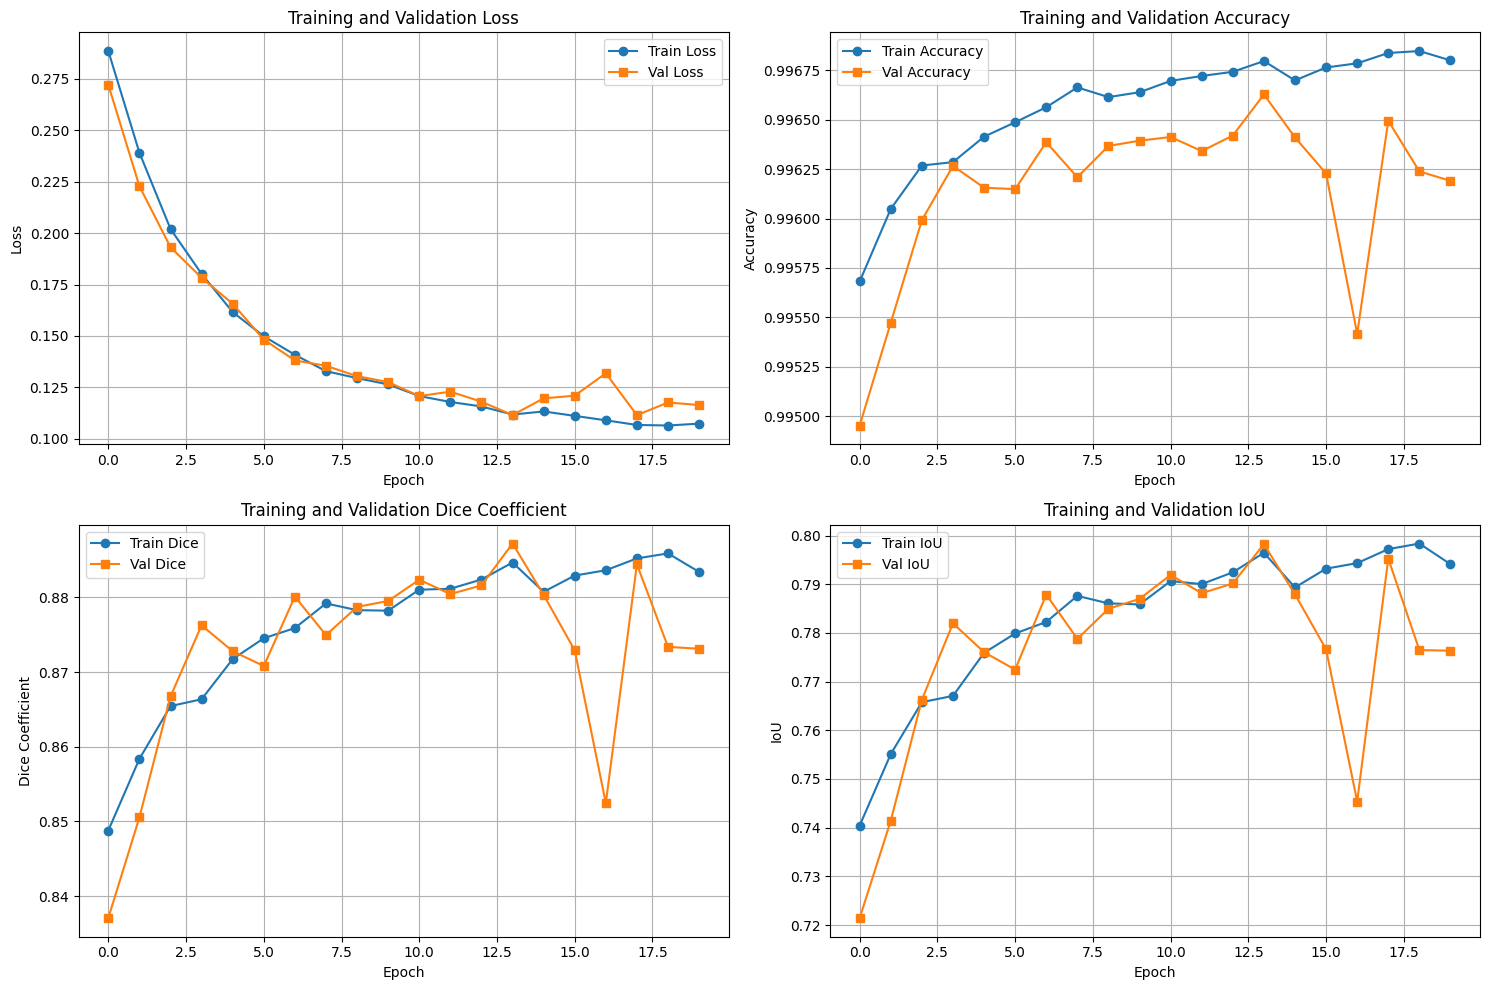


Training history plots saved to training_history.png


In [14]:
# Cell 9: Plot Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history['train_dice'], label='Train Dice', marker='o')
axes[1, 0].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice Coefficient')
axes[1, 0].set_title('Training and Validation Dice Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history['train_iou'], label='Train IoU', marker='o')
axes[1, 1].plot(history['val_iou'], label='Val IoU', marker='s')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('IoU')
axes[1, 1].set_title('Training and Validation IoU')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nTraining history plots saved to training_history.png')

Loaded model from epoch 19, best Dice = 0.8872

Visualizing 20 randomly selected test images...

Sample 1: Dice = 0.8327, IoU = 0.7134
Sample 2: Dice = 0.8707, IoU = 0.7711
Sample 3: Dice = 0.8900, IoU = 0.8018
Sample 4: Dice = 0.9147, IoU = 0.8429
Sample 5: Dice = 0.8085, IoU = 0.6786
Sample 6: Dice = 0.9417, IoU = 0.8898
Sample 7: Dice = 0.8837, IoU = 0.7917
Sample 8: Dice = 0.9171, IoU = 0.8469
Sample 9: Dice = 0.8573, IoU = 0.7503
Sample 10: Dice = 0.8482, IoU = 0.7365
Sample 11: Dice = 0.9230, IoU = 0.8570
Sample 12: Dice = 0.8925, IoU = 0.8059
Sample 13: Dice = 0.8429, IoU = 0.7284
Sample 14: Dice = 0.8919, IoU = 0.8049
Sample 15: Dice = 0.9167, IoU = 0.8463
Sample 16: Dice = 0.9298, IoU = 0.8688
Sample 17: Dice = 0.6269, IoU = 0.4566
Sample 18: Dice = 0.8593, IoU = 0.7533
Sample 19: Dice = 0.8698, IoU = 0.7696
Sample 20: Dice = 0.9248, IoU = 0.8602


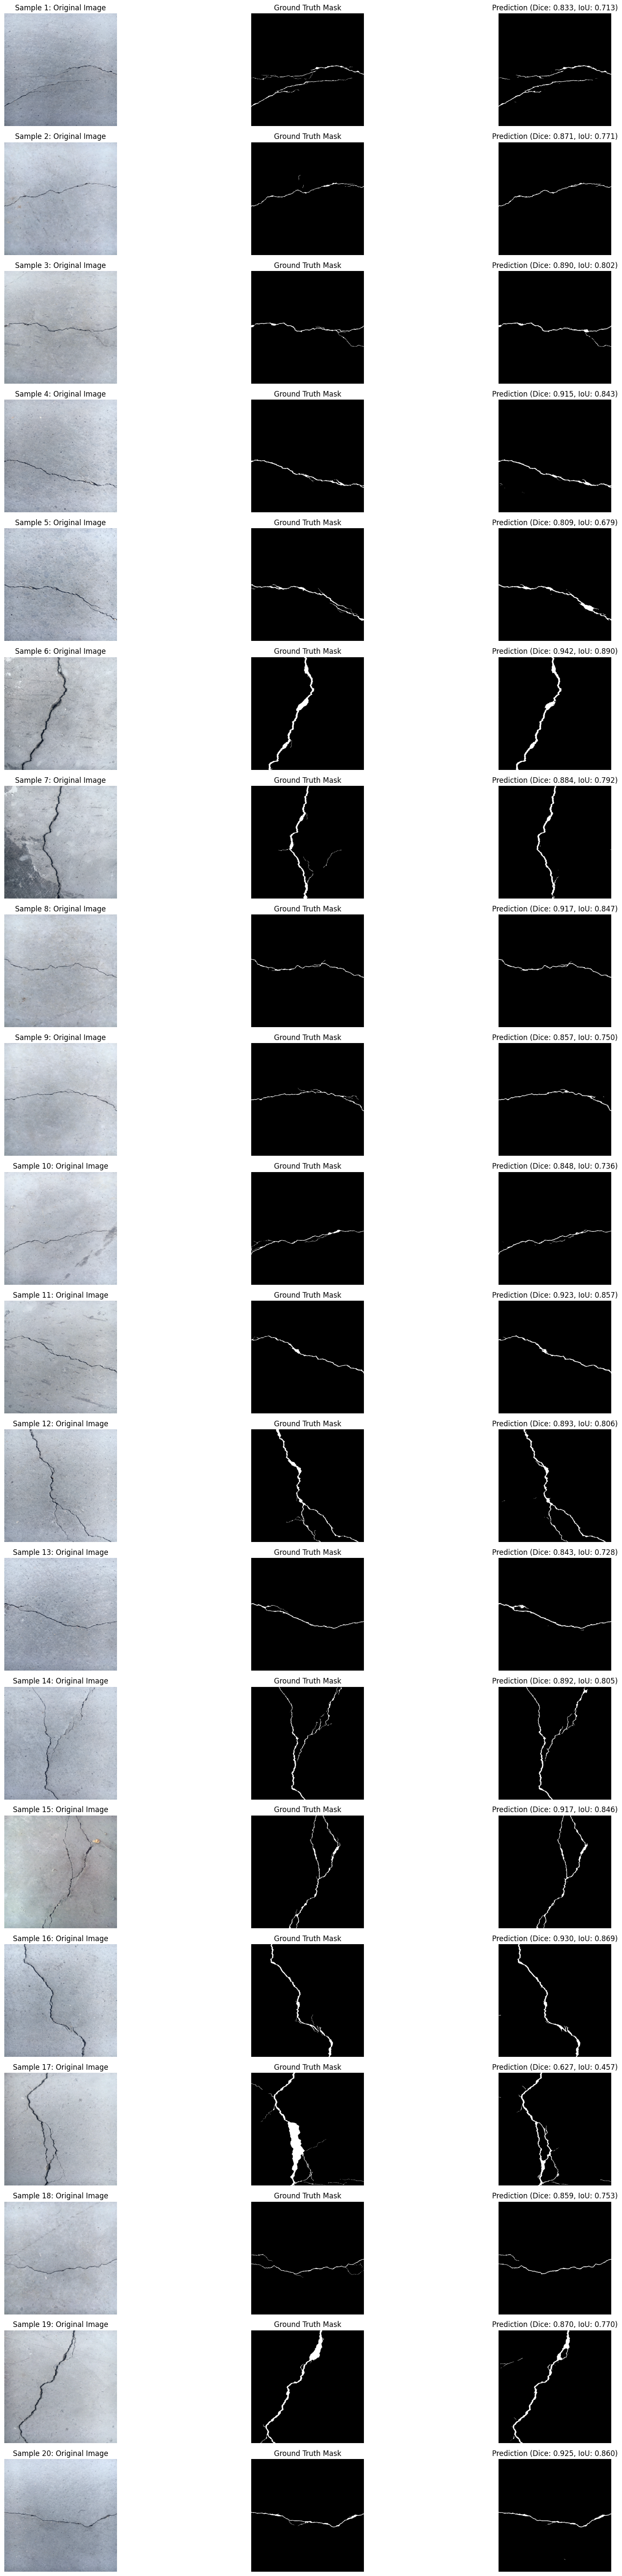


Test results saved to test_results_20_samples.png


In [24]:
# Cell 10: Load model từ checkpoint và visualize 20 ảnh test

# 1. Load checkpoint đúng cách
checkpoint_path = '/content/drive/MyDrive/deeplearning_final/checkpoint_unet.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print(f"Loaded model from epoch {checkpoint['epoch']}, best Dice = {checkpoint['best_dice']:.4f}")

# 2. Chọn ngẫu nhiên 20 ảnh test
all_test_indices = list(range(len(test_dataset)))
random.shuffle(all_test_indices)
selected_indices = all_test_indices[:20]

print(f'\nVisualizing 20 randomly selected test images...\n')

fig = plt.figure(figsize=(20, 60))

for i, idx in enumerate(selected_indices):
    image, mask = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image_input)
        pred_prob = torch.sigmoid(logits)
        pred_mask = (pred_prob > 0.5).float()

    # Chuẩn bị dữ liệu để vẽ
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    mask_np = mask.squeeze().cpu().numpy()
    pred_mask_np = pred_mask.squeeze().cpu().numpy()

    # Tính Dice/IoU cho từng ảnh
    dice = calculate_dice_coefficient(pred_prob.cpu(), mask.unsqueeze(0))
    iou = calculate_iou(pred_prob.cpu(), mask.unsqueeze(0))

    # Cột 1: ảnh gốc
    ax1 = plt.subplot(20, 3, i*3 + 1)
    ax1.imshow(image_np)
    ax1.set_title(f'Sample {i+1}: Original Image')
    ax1.axis('off')

    # Cột 2: mask ground truth
    ax2 = plt.subplot(20, 3, i*3 + 2)
    ax2.imshow(mask_np, cmap='gray')
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')

    # Cột 3: mask dự đoán
    ax3 = plt.subplot(20, 3, i*3 + 3)
    ax3.imshow(pred_mask_np, cmap='gray')
    ax3.set_title(f'Prediction (Dice: {dice:.3f}, IoU: {iou:.3f})')
    ax3.axis('off')

    print(f'Sample {i+1}: Dice = {dice:.4f}, IoU = {iou:.4f}')

plt.tight_layout()
plt.savefig('test_results_20_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nTest results saved to test_results_20_samples.png')


Original t=0.5: Dice=0.6269, IoU=0.4566
Best   t=0.100, iter=0: Dice=0.6542, IoU=0.4862


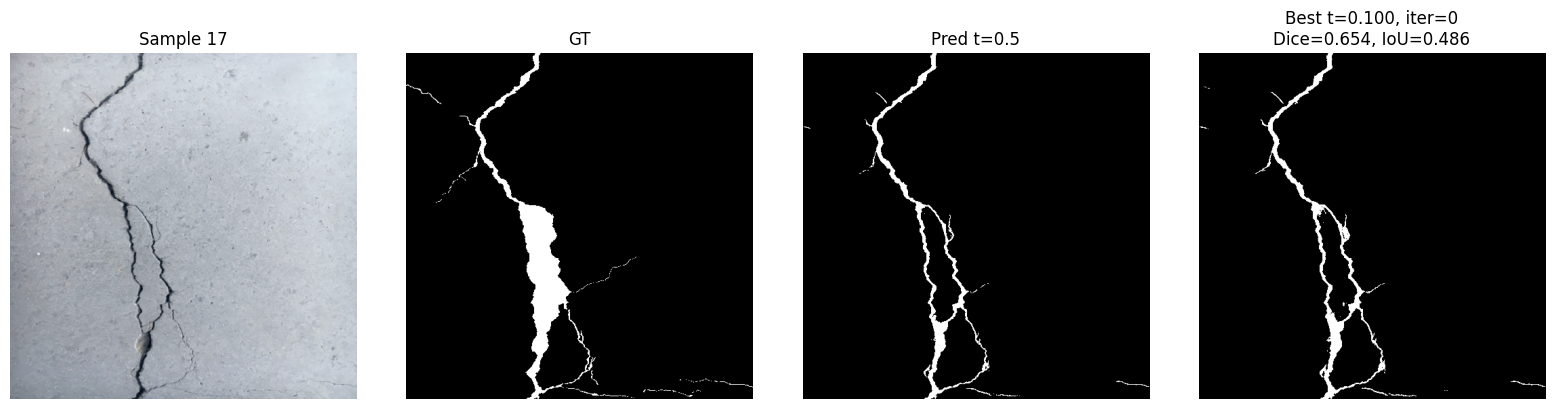

In [27]:
# Cải thiện Sample 17
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()

# Lấy lại sample 17
target_pos = 16
target_idx = selected_indices[target_pos]

image, mask = test_dataset[target_idx]
image_input = image.unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(image_input)
    prob = torch.sigmoid(logits)   # (1,1,H,W)

mask_4d = mask.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

def tensor_iou(pred_bin, gt_bin):
    return calculate_iou(pred_bin.cpu(), gt_bin.cpu())

def tensor_dice(pred_bin, gt_bin):
    return calculate_dice_coefficient(pred_bin.cpu(), gt_bin.cpu())

best_iou = -1.0
best_dice = -1.0
best_t = 0.5
best_iter = 0
best_pred = None

# Quét nhiều threshold + số lần "dilation"
for t in np.linspace(0.1, 0.7, 61):          # t = 0.10 ... 0.70
    base = (prob > t).float()               # (1,1,H,W)
    for it in range(0, 5):                  # 0,1,2,3,4 lần mở rộng
        if it == 0:
            dil = base
        else:
            # dùng max_pool2d kernel 3x3 như dilation
            dil = F.max_pool2d(dil, kernel_size=3, stride=1, padding=1)

        d = tensor_dice(dil, mask_4d)
        j = tensor_iou(dil, mask_4d)

        if j > best_iou:
            best_iou = j
            best_dice = d
            best_t = t
            best_iter = it
            best_pred = dil.clone()

print(f'Original t=0.5: Dice={tensor_dice((prob>0.5).float(), mask_4d):.4f}, '
      f'IoU={tensor_iou((prob>0.5).float(), mask_4d):.4f}')
print(f'Best   t={best_t:.3f}, iter={best_iter}: Dice={best_dice:.4f}, IoU={best_iou:.4f}')

# Vẽ so sánh
image_np = image.permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
mask_np = mask.squeeze().cpu().numpy()
orig_pred_np = (prob > 0.5).float().squeeze().cpu().numpy()
best_pred_np = best_pred.squeeze().cpu().numpy()

plt.figure(figsize=(16, 4))
ax1 = plt.subplot(1,4,1); ax1.imshow(image_np); ax1.set_title('Sample 17'); ax1.axis('off')
ax2 = plt.subplot(1,4,2); ax2.imshow(mask_np, cmap='gray'); ax2.set_title('GT'); ax2.axis('off')
ax3 = plt.subplot(1,4,3); ax3.imshow(orig_pred_np, cmap='gray')
ax3.set_title('Pred t=0.5'); ax3.axis('off')
ax4 = plt.subplot(1,4,4); ax4.imshow(best_pred_np, cmap='gray')
ax4.set_title(f'Best t={best_t:.3f}, iter={best_iter}\nDice={best_dice:.3f}, IoU={best_iou:.3f}')
ax4.axis('off')
plt.tight_layout()
plt.show()


Đã load mô hình từ epoch 19 với best val Dice = 0.8872

Đang đánh giá trên toàn bộ test set...

📊 KẾT QUẢ TRUNG BÌNH TRÊN TEST SET:
  Loss           : 0.1164
  Pixel Accuracy : 0.9962
  Dice           : 0.8731
  IoU            : 0.7764

Đang hiển thị 3 ảnh test (index trong test_dataset: [10, 3, 23])...

Ảnh #1 (index 10): Acc=0.9981, Dice=0.8900, IoU=0.8018
Ảnh #2 (index 3): Acc=0.9937, Dice=0.8635, IoU=0.7599
Ảnh #3 (index 23): Acc=0.9963, Dice=0.8943, IoU=0.8088


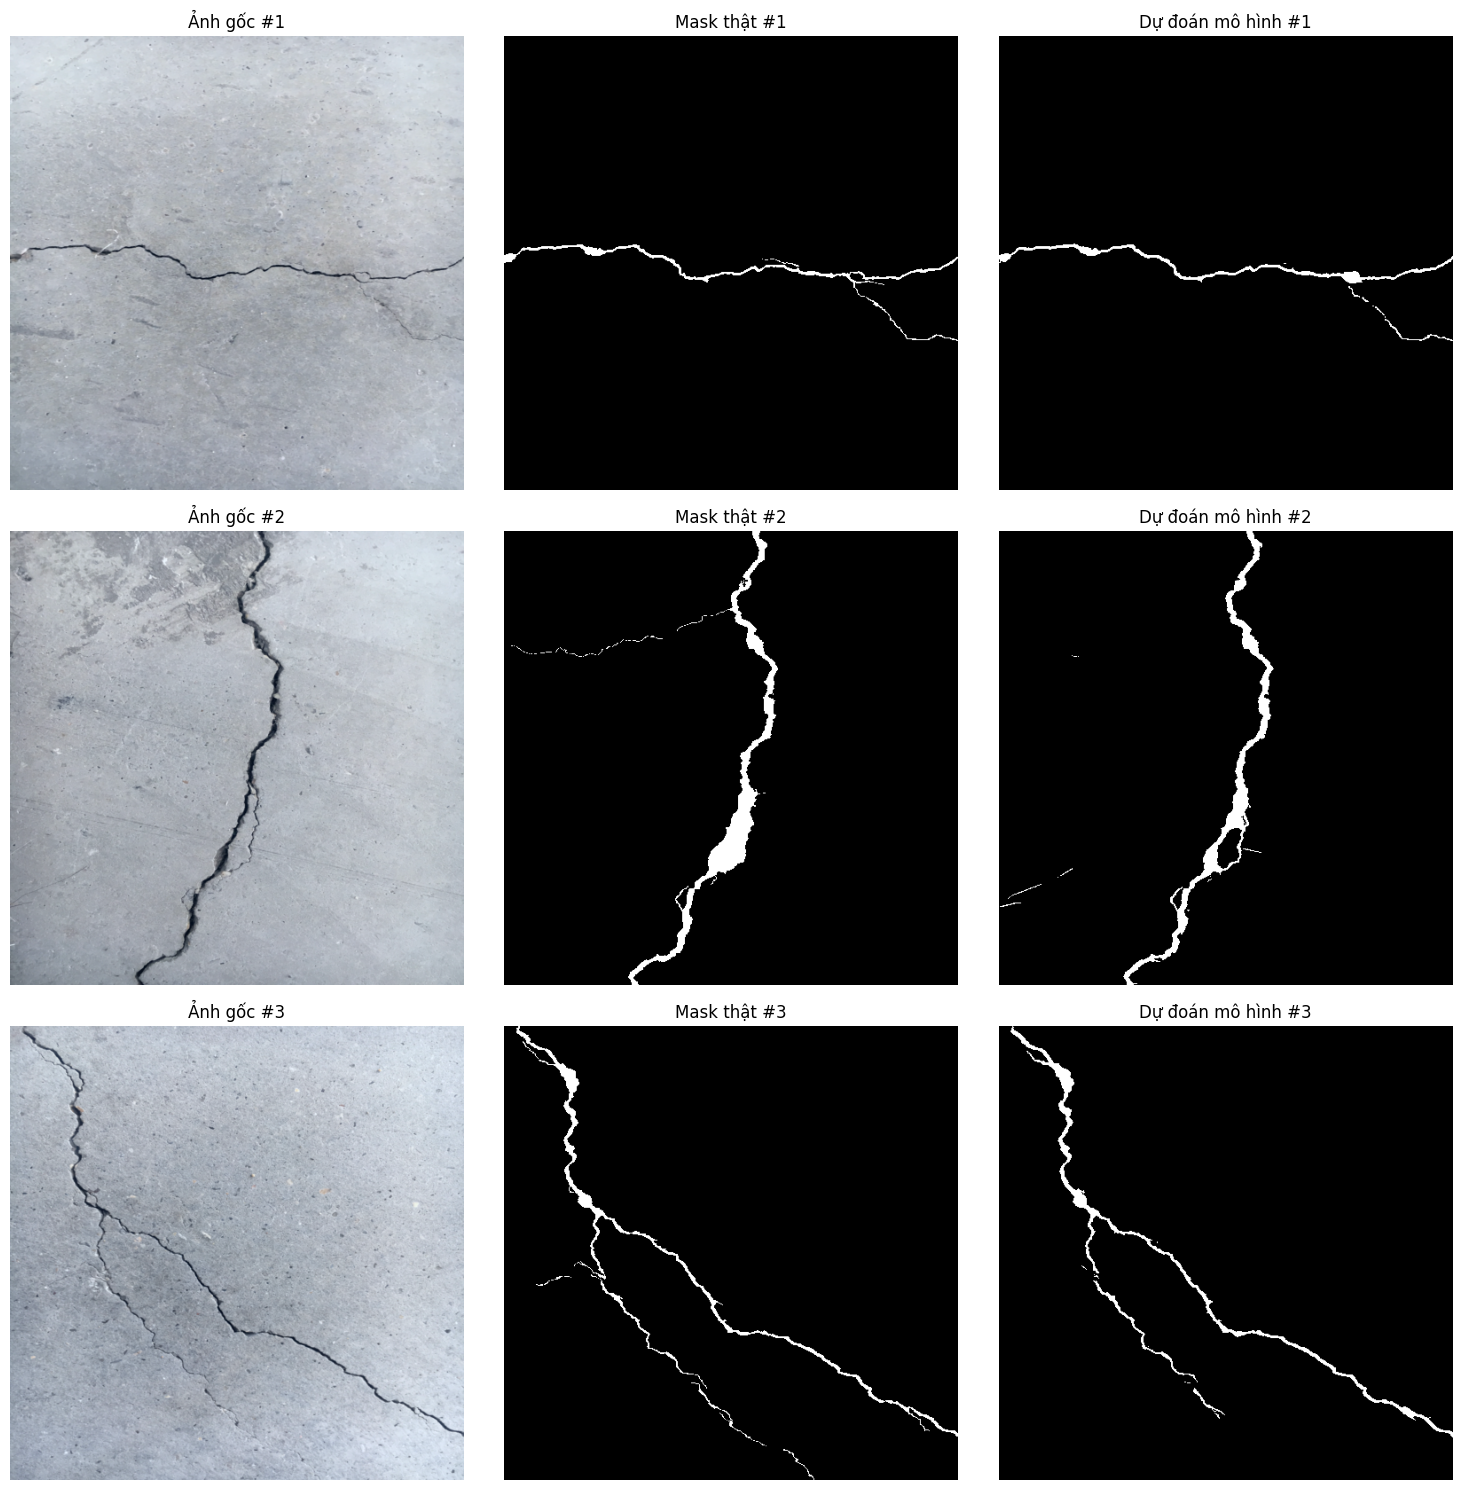

In [30]:
# Cell: Đánh giá mô hình + hiển thị so sánh ảnh gốc / mask thật / mask dự đoán

import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. Load model từ checkpoint
checkpoint_path = '/content/drive/MyDrive/deeplearning_final/checkpoint_unet.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Đã load mô hình từ epoch {checkpoint['epoch']} với best val Dice = {checkpoint['best_dice']:.4f}")

# 2. Tính accuracy, Dice, IoU trung bình trên toàn bộ test set
print("\nĐang đánh giá trên toàn bộ test set...")

running_loss = 0.0
running_acc = 0.0
running_dice = 0.0
running_iou = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)
        loss = criterion(logits, masks)

        probs = torch.sigmoid(logits)
        acc = calculate_pixel_accuracy(probs, masks)
        dice = calculate_dice_coefficient(probs, masks)
        iou = calculate_iou(probs, masks)

        running_loss += loss.item()
        running_acc += acc
        running_dice += dice
        running_iou += iou
        num_batches += 1

test_loss = running_loss / num_batches
test_acc = running_acc / num_batches
test_dice = running_dice / num_batches
test_iou = running_iou / num_batches

print("\n📊 KẾT QUẢ TRUNG BÌNH TRÊN TEST SET:")
print(f"  Loss           : {test_loss:.4f}")
print(f"  Pixel Accuracy : {test_acc:.4f}")
print(f"  Dice           : {test_dice:.4f}")
print(f"  IoU            : {test_iou:.4f}")

# 3. Hiển thị vài ảnh test: ảnh gốc, mask thật, mask dự đoán
num_show = 3  # đổi thành 1, 5... tùy bạn
indices = list(range(len(test_dataset)))
random.shuffle(indices)
selected_indices = indices[:num_show]

print(f"\nĐang hiển thị {num_show} ảnh test (index trong test_dataset: {selected_indices})...\n")

fig = plt.figure(figsize=(15, 5 * num_show))

for i, idx in enumerate(selected_indices):
    image, mask = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image_input)
        prob = torch.sigmoid(logits)
        pred_mask = (prob > 0.5).float()

    # Tính metric cho từng ảnh
    acc_img = calculate_pixel_accuracy(prob.cpu(), mask.unsqueeze(0))
    dice_img = calculate_dice_coefficient(prob.cpu(), mask.unsqueeze(0))
    iou_img = calculate_iou(prob.cpu(), mask.unsqueeze(0))

    print(f"Ảnh #{i+1} (index {idx}): Acc={acc_img:.4f}, Dice={dice_img:.4f}, IoU={iou_img:.4f}")

    # Chuẩn bị dữ liệu để vẽ
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred_mask.squeeze().cpu().numpy()

    # Cột 1: Ảnh gốc
    ax1 = plt.subplot(num_show, 3, 3*i + 1)
    ax1.imshow(img_np)
    ax1.set_title(f'Ảnh gốc #{i+1}')
    ax1.axis('off')

    # Cột 2: Mask thật (BW_test)
    ax2 = plt.subplot(num_show, 3, 3*i + 2)
    ax2.imshow(mask_np, cmap='gray')
    ax2.set_title(f'Mask thật #{i+1}')
    ax2.axis('off')

    # Cột 3: Mask dự đoán mô hình
    ax3 = plt.subplot(num_show, 3, 3*i + 3)
    ax3.imshow(pred_np, cmap='gray')
    ax3.set_title(f'Dự đoán mô hình #{i+1}')
    ax3.axis('off')

plt.tight_layout()
plt.show()
